Averaging multiple noisy sets of weights during the learning process may paradoxically sound less desirable than tuning the optimization process itself, but may prove a desirable solution, especially for very large neural networks that may take days, weeks, or even months to train.

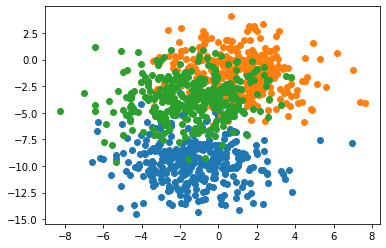

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
	# select indices of points with the class label
	row_ix = where(y == class_value)
	# scatter plot for points with a different color
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
pyplot.show()

In [3]:
# develop an mlp for blobs dataset
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [5]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [6]:
# fit model
#history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
!pip install h5py
# fit model
n_epochs, n_save_after = 500, 490
for i in range(n_epochs):
	# fit model for a single epoch
	model.fit(trainX, trainy, epochs=1, verbose=0)
	# check if we should save the model
	if i >= n_save_after:
		model.save('model_' + str(i) + '.h5')

In [7]:
# average the weights of multiple loaded models
from keras.models import load_model
from keras.models import clone_model
from numpy import average
from numpy import array
# load models from file
def load_all_models(n_start, n_end):
	all_models = list()
	for epoch in range(n_start, n_end):
		# define filename for this ensemble
		filename = 'model_' + str(epoch) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [8]:
# load models in order
members = load_all_models(490, 500)
print('Loaded %d models' % len(members))

>loaded model_490.h5
>loaded model_491.h5
>loaded model_492.h5
>loaded model_493.h5
>loaded model_494.h5
>loaded model_495.h5
>loaded model_496.h5
>loaded model_497.h5
>loaded model_498.h5
>loaded model_499.h5
Loaded 10 models


In [9]:
# create a model from the weights of multiple models
def model_weight_ensemble(members, weights):
	# determine how many layers need to be averaged
	n_layers = len(members[0].get_weights())
	# create an set of average model weights
	avg_model_weights = list()
	for layer in range(n_layers):
		# collect this layer from each model
		layer_weights = array([model.get_weights()[layer] for model in members])
		# weighted average of weights for this layer
		avg_layer_weights = average(layer_weights, axis=0, weights=weights)
		# store average layer weights
		avg_model_weights.append(avg_layer_weights)
	# create a new model with the same structure
	model = clone_model(members[0])
	# set the weights in the new
	model.set_weights(avg_model_weights)
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [10]:
# prepare an array of equal weights
n_models = len(members)
weights = [1/n_models for i in range(1, n_models+1)]
# create a new model with the weighted average of all model weights
model = model_weight_ensemble(members, weights)
# summarize the created model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [11]:
from math import exp
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # reverse loaded models so we build the ensemble with the last models first
  members = list(reversed(members))
  # select a subset of members
  subset = members[:n_members]
  # prepare an array of equal weights
  # weights = [1.0/n_members for i in range(1, n_members+1)]
  # prepare an array of exponentially decreasing weights
  alpha=2.0
  weights = [exp(-i/alpha) for i in range(1, n_members+1)]
  # create a new model with the weighted average of all model weights
  model = model_weight_ensemble(subset, weights)
  # make predictions and evaluate accuracy
  _, test_acc = model.evaluate(testX, testy, verbose=0)
  return test_acc

In [12]:
# evaluate the model
#_, train_acc = model.evaluate(trainX, trainy, verbose=0)
#_, test_acc = model.evaluate(testX, testy, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [13]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	_, single_score = members[i-1].evaluate(testX, testy, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

> 1: single=0.794, ensemble=0.804
> 2: single=0.794, ensemble=0.802
> 3: single=0.801, ensemble=0.797
> 4: single=0.807, ensemble=0.799
> 5: single=0.808, ensemble=0.800
> 6: single=0.795, ensemble=0.801
> 7: single=0.793, ensemble=0.800
> 8: single=0.794, ensemble=0.800
> 9: single=0.789, ensemble=0.800
> 10: single=0.804, ensemble=0.800


In [ ]:
# learning curves of model accuracy
#pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
#pyplot.legend()
#pyplot.show()

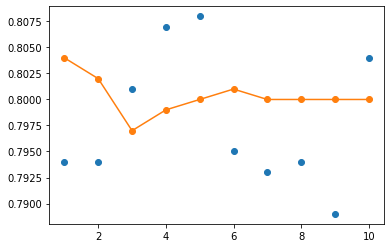

In [14]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()